In [21]:
import os
files = os.listdir('./manual')
files = files[1:]

In [22]:
import cv2

In [70]:
train_img = []

# 종이 검출

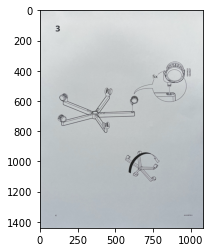

In [288]:
def reorderPts(pts): # 꼭지점 순서 정렬
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx]  # x좌표로 정렬
    
    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]] # 스와핑

    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]] # 스와핑

    return pts

# output 세로, 가로 크기
dw, dh = 1080, 1440
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)


img = cv2.imread('aw.jpg')
src_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 외곽선 검출 및 명함 검출
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cpy = img.copy()
for pts in contours:
    # 너무 작은 객체는 무시
    if cv2.contourArea(pts) < 1000:
        continue

    # 외곽선 근사화
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # 컨벡스가 아니고, 사각형이 아니면 무시
    if not cv2.isContourConvex(approx) or len(approx) != 4:
        continue

    cv2.polylines(cpy, [approx], True, (0, 255, 0), 2, cv2.LINE_AA)
    srcQuad = reorderPts(approx.reshape(4, 2).astype(np.float32))

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(img, pers, (dw, dh))
plt.imshow(dst)
plt.show()

# 좌측 상단 숫자 검출

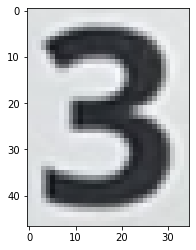

In [289]:
rgb = dst.copy()
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(bw.shape, dtype=np.uint8)

tmp = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
    if r > 0.45 and w > 8 and w < 50 and h > 8:
        cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
        tmp.append(dst[y:y+h-1, x:x+w-1])
        
# cv2.imshow('rects', large)
# cv2.waitKey()

plt.imshow(tmp[1])
plt.show()

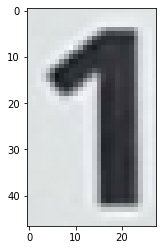

In [95]:
plt.imshow(tmp[2])
plt.show()

In [97]:
train_img.append(tmp[2])

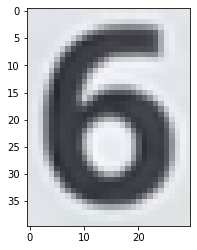

In [120]:
plt.imshow(cv2.resize(tmp[1], (32, 32), interpolation = cv2.INTER_AREA))
plt.show()

In [291]:
cv2.imwrite('./manual/three.jpg', cv2.resize(tmp[1], (32, 32), interpolation = cv2.INTER_AREA))

True

In [179]:
for i in range(6):
    train_img[i] = cv2.resize(train_img[i], (32, 32), interpolation = cv2.INTER_AREA)
    cv2.imwrite('./manual/' + number_img[i], train_img[i])

In [157]:
cv2.imwrite('./manual/seven.jpg',train_img[5])

True

# 이미지 가져와서 증강 (-30 ~ 30 도 각도 변경)

In [11]:
import cv2
import matplotlib.pyplot as plt
number_img = ['one.jpg', 'two.jpg', 'three.jpg', 'four.jpg', 'five.jpg', 'six.jpg', 'seven.jpg']

In [12]:
train_img = []
for per in number_img:
    train_img.append(cv2.imread('./manual/' + per))

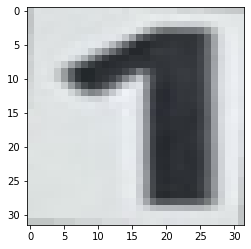

In [13]:
def im_rotate(img, degree):
    h, w = img.shape[:-1]
    crossLine = int(((w * h + h * w) ** 0.5))
    centerRotatePT = int(w / 2), int(h / 2)
    new_h, new_w = h, w
    rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1)
    result = cv2.warpAffine(img, rotatefigure, (new_w, new_h))
    return result


result = im_rotate(train_img[0], -0.5)
plt.imshow(result)
plt.show()

In [31]:
X_train = []
for i in range(-60, 60):
    X_train.append(im_rotate(train_img[0], i*0.5))
    X_train.append(im_rotate(train_img[1], i*0.5))
    X_train.append(im_rotate(train_img[2], i*0.5))
    X_train.append(im_rotate(train_img[3], i*0.5))
    X_train.append(im_rotate(train_img[4], i*0.5))
    X_train.append(im_rotate(train_img[5], i*0.5))
    X_train.append(im_rotate(train_img[6], i*0.5))

In [32]:
import numpy as np
X_train = np.array(X_train)
X_train.shape

(840, 32, 32, 3)

In [33]:
y_train = [1, 2, 3, 4, 5, 6, 7] * 120
y_train = np.array(y_train)

In [34]:
print(X_train.shape, y_train.shape)

(840, 32, 32, 3) (840,)


# VGGNet 구성하여 학습

In [51]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
def VGG16_Brief(classes=10): # classes = 감지할 클래스 수
    img_rows, img_cols = 32, 32
    img_channels = 3    
    img_dim = (img_rows, img_cols, img_channels) #차원..shape 정의..
    
    img_input = Input(shape=img_dim) #튜플.. 변경 x
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) #1층
    x = Dropout(0.256)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x) #2층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #2층 maxpool


    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) #3층
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) #4층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #4층 maxpool
    #x = Dropout(0.25)(x)

    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) #5층
    x = Dropout(0.25)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) #6층
   # x = Dropout(0.15)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) #7층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #7층 maxpool
    #x = Dropout(0.2)(x)

#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #8층
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #9층
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #10층
#     x = MaxPooling2D((2,2),strides=(2,2))(x) #10층 maxpool

#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #11층
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #12층
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #13층
#     x = MaxPooling2D((2,2),strides=(2,2))(x) #13층 maxpool

    x = Flatten()(x)
    #x = Dense(1024, activation = 'relu')(x) #14층
    #x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x) #15층
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

model = VGG16_Brief(classes = 10)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 dropout_18 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_19 (Dropout)        (None, 16, 16, 64)        0         
                                                           

In [53]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=10, epochs=50)

Epoch 1/50
84/84 [==============================] - 2s 15ms/step - loss: 0.1322 - accuracy: 0.9714
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 0.2061 - accuracy: 0.9655
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 0.1765 - accuracy: 0.9726
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 0.1261 - accuracy: 0.9881
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0862 - accuracy: 0.9905
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 0.1073 - accuracy: 0.9893
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 0.1241 - accuracy: 0.9857
Epoch 8/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0019 - accuracy: 0.9988
Epoch 9/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0155 - accuracy: 0.9940
Epoch 10/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0530 - accuracy: 0.9940
Epoch 11/

# 종이 검출 및 숫자 모델 output

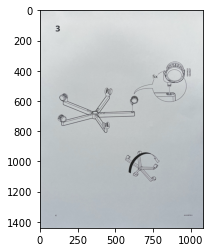

In [55]:
def reorderPts(pts): # 꼭지점 순서 정렬
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx]  # x좌표로 정렬
    
    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]] # 스와핑

    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]] # 스와핑

    return pts

# output 세로, 가로 크기
dw, dh = 1080, 1440
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)


img = cv2.imread('aw.jpg')
src_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 외곽선 검출 및 명함 검출
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cpy = img.copy()
for pts in contours:
    # 너무 작은 객체는 무시
    if cv2.contourArea(pts) < 1000:
        continue

    # 외곽선 근사화
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # 컨벡스가 아니고, 사각형이 아니면 무시
    if not cv2.isContourConvex(approx) or len(approx) != 4:
        continue

    cv2.polylines(cpy, [approx], True, (0, 255, 0), 2, cv2.LINE_AA)
    srcQuad = reorderPts(approx.reshape(4, 2).astype(np.float32))

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(img, pers, (dw, dh))
plt.imshow(dst)
plt.show()

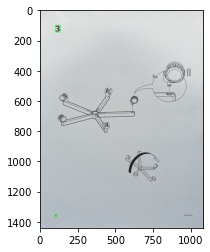

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

dd = cv2.imread('ttee.jpg')
rgb = dst.copy()
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(bw.shape, dtype=np.uint8)

tmp = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
    if r > 0.45 and w > 8 and w < 50 and h > 8:
        cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
        tmp.append(dst[y:y+h-1, x:x+w-1])
        
# cv2.imshow('rects', large)
# cv2.waitKey()

plt.imshow(rgb)
plt.show()

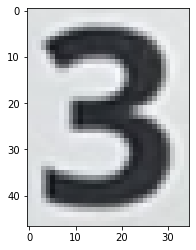

In [57]:
plt.imshow(tmp[1])
plt.show()

In [58]:
at = cv2.resize(tmp[1], (32,32), interpolation = cv2.INTER_AREA)

<BarContainer object of 10 artists>

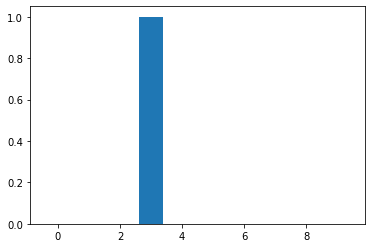

In [60]:
#vgg16
pred = model.predict(at.reshape(1, 32, 32, 3))
plt.bar(range(10), pred[0])

<BarContainer object of 10 artists>

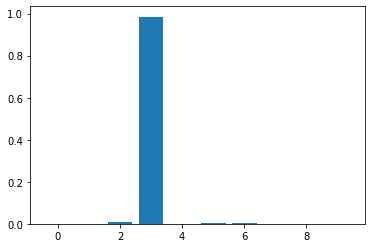

In [41]:
import matplotlib.pyplot as plt

#resnet
pred = head_model_res.predict(at.reshape(1, 32, 32, 3))
plt.bar(range(10), pred[0])

In [42]:
p = list(pred[0])
tmp = max(p)
index = p.index(tmp)
print(tmp, index)

0.9852131 3


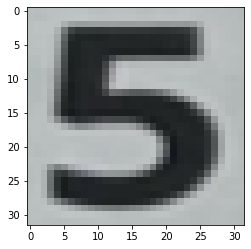

In [246]:
plt.imshow(at)
plt.show()

In [316]:
head_model_res.save('./number_classification.h5')

In [61]:
model.save('./num_class.h5')